# Introduction
This is the code module which creates the results for the single step process

# Imports

In [237]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
# from tensorflow_addons.losses import pinball_loss
from tensorflow import function as tf_fun
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil, floor
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt

from time import perf_counter
from scipy.stats import norm
from matplotlib import ticker

from importlib import reload

from numpy.random import seed   
from tensorflow.random import set_seed as tf_seed

from copy import deepcopy

tf_seed(1234) ; seed(1234)

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

# Simulate W1 & W2 Pahs

In [238]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

In [239]:
""" Global Variables """
n_paths   = ceil(np.log2(8_000)) ; print(f'Paths: {2**n_paths:,.0f}')# 8000 paths for both Y and N
dt        = 1/(12) #daily interval, Local: use greater than 42

rebalancing = 10 # 1 Step

P = 100 # premium per client
N = 10_000 # number of clients
ADJUSTMENT_FACTOR = P * N

Paths: 8,192


## Y - Geometric Brownian Motion

Number of steps: 121 
dt         = 0.083 year
----------------------------------------------------------------
Time to simulate: 0.058sec
mean Yt    = 2.220114
e^(mu * T) = 2.225541 
Diff       = -0.005427


[]

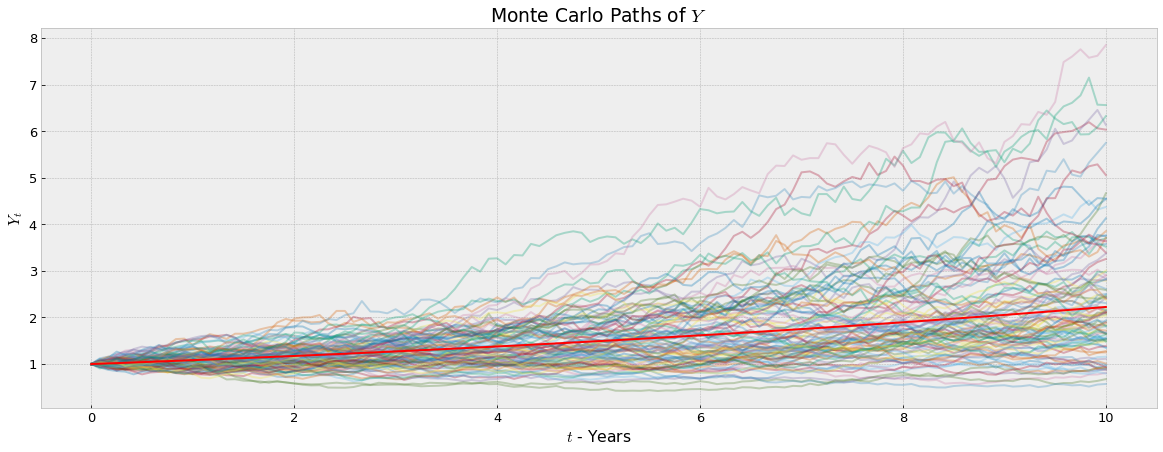

In [240]:
Y       = 1 # Starting value of stock
T       = 10 # Years
mu      = 0.08 #drift parameter
r       = 0.03 # risk
sigma   = 0.15

n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')

timer=perf_counter()

""" Simulate Fund Price """
W1      = sobol_norm(n_paths, d=n_time_steps, seed=1235)
Y_paths = np.empty((2**n_paths, n_time_steps))
Y_paths[:,0] = Y

print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    Y_paths[:,t] = Y_paths[:,t-1] + Y_paths[:,t-1] * (mu*dt + sigma * np.sqrt(dt)*W1[:,t]).squeeze()

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, Y_paths.shape)
print(f'Time to simulate: {perf_counter()-timer:.3f}sec')

print(f'mean Yt    = {np.nanmean(Y_paths[:,-1]):.6f}')
print(f'e^(mu * T) = {np.exp(mu*T):.6f} \nDiff       = {np.nanmean(Y_paths[:,-1])-Y*np.exp(mu*T):.6f}')

rdf = pd.DataFrame(Y_paths.T, index=(np.linspace(0,T, n_time_steps)))
ax = rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y_t$', xlabel=r'$t$ - Years', title=r'Monte Carlo Paths of $Y$') 
ax.plot(np.linspace(0,T, n_time_steps), np.exp(mu*np.linspace(0,T, n_time_steps)), c='r') ; plt.plot()


# N(T) - Simulation

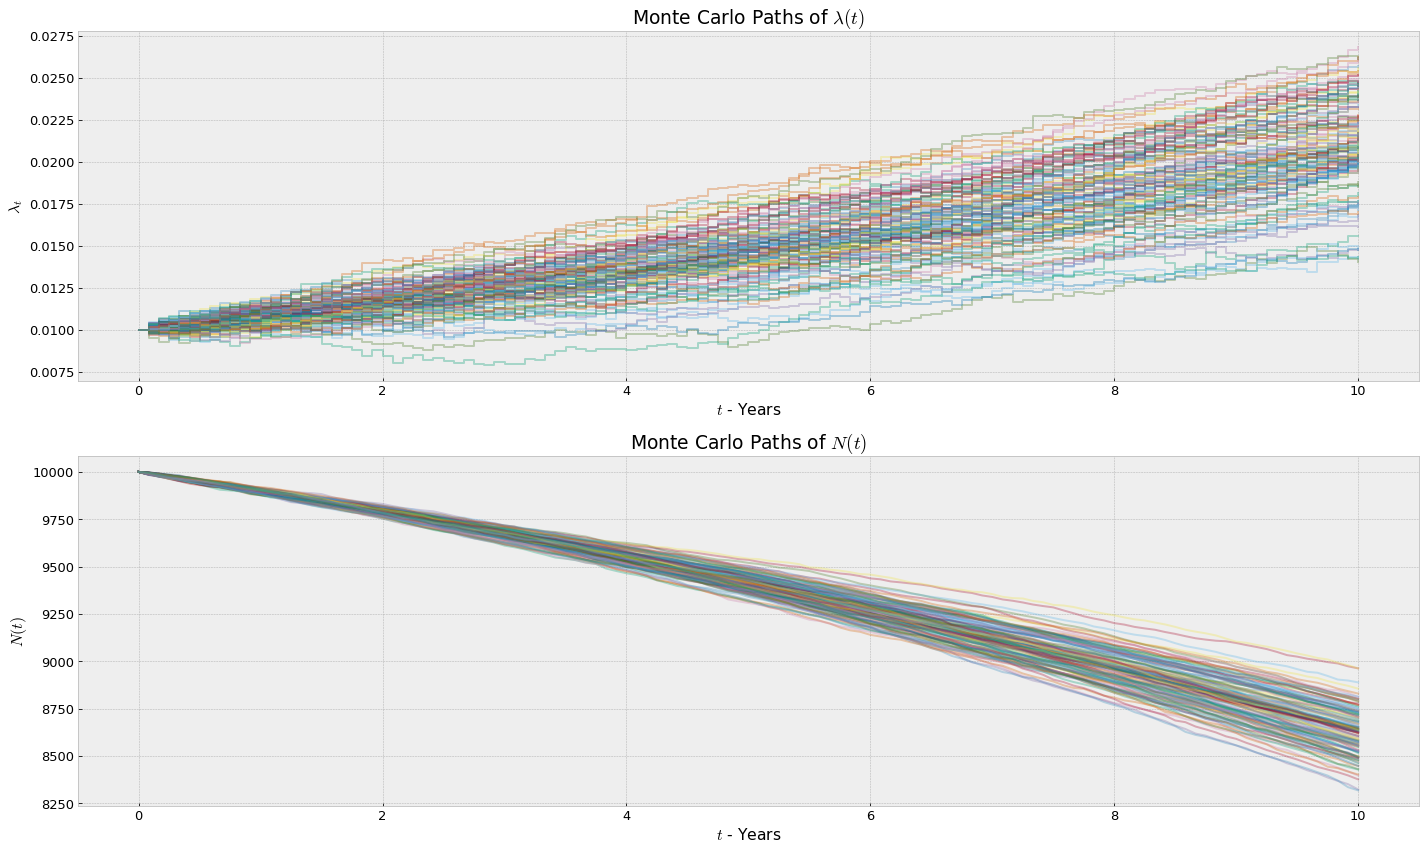

Statistics about N(T) 
---------------------
count   8,192
mean    8,615
std       132
min     8,158
50%     8,618
90%     8,784
95%     8,830
99%     8,920
max     9,208


In [241]:
x   = 55.0 # years old
l0  = 0.01
c   = 0.075
ita = 0.000597

""" Simulate Fund Price """
W2      = sobol_norm(n_paths, d=n_time_steps)
L_paths = np.empty((2**n_paths, n_time_steps))
L_paths[:,0] = l0
for t in range(1,n_time_steps):
    L_paths[:,t] = L_paths[:,t-1] + (c * L_paths[:,t-1] * dt + ita * np.sqrt(dt)*W2[:,t]).squeeze()

N_paths = np.empty((2**n_paths, n_time_steps), dtype=int)
N_paths[:,0] = N
""" Binomial Distribution of N(t) """
for t in range(1,n_time_steps):
    probabilities = np.exp(-L_paths[:,t]*dt)
    np.random.seed(1234+t) # to ensure reproducible results
    N_paths[:,t]  = np.random.binomial(N_paths[:,t-1], probabilities)

fig, axs = plt.subplots(2, figsize=(20,12))

Ldf = pd.DataFrame(L_paths.T, index=(np.linspace(0,T, n_time_steps)))
Ldf.sample(128, axis=1).plot(drawstyle="steps-post", legend=False, alpha=.3, ylabel=r'$\lambda_t$', xlabel=r'$t$ - Years', ax=axs[0], title=r'Monte Carlo Paths of $\lambda(t)$') 

Ndf = pd.DataFrame(N_paths.T, index=(np.linspace(0,T, n_time_steps)))
Ndf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$N(t)$', xlabel=r'$t$ - Years', ax=axs[1], title=r'Monte Carlo Paths of $N(t)$') 

plt.tight_layout() ; plt.show()

str_form = lambda s: f'{s:,.0f}'
print('Statistics about N(T) \n---------------------')
print(Ndf.loc[10].describe(percentiles=[.90, .95, .99]).to_string(float_format=str_form))


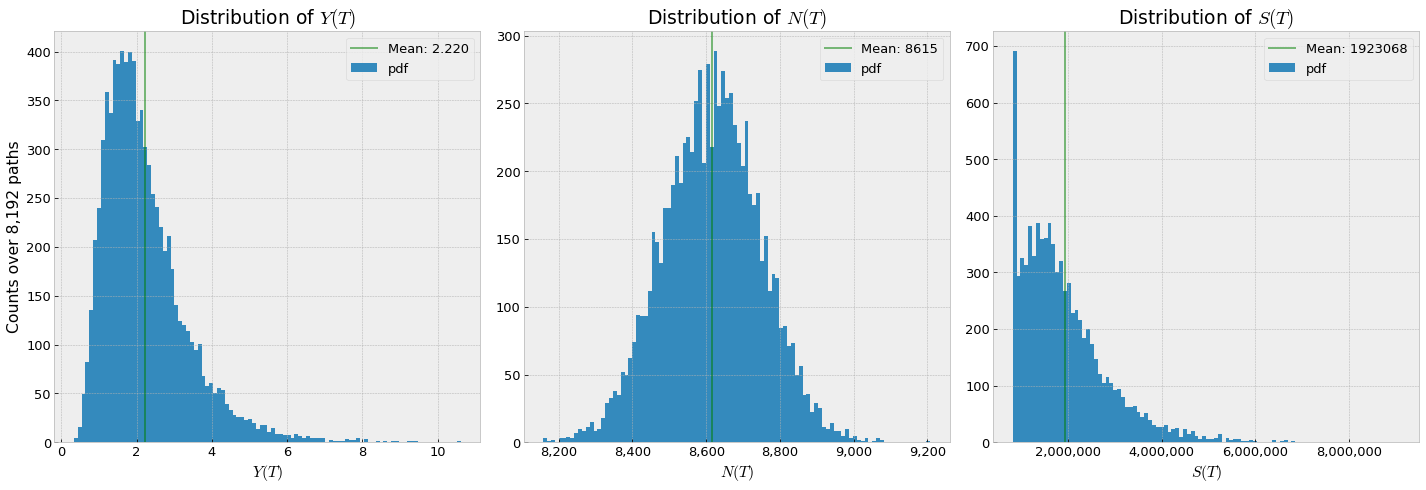

-------------------------------------
E[Y(T)]          = 2.233
E[Y(T)]*e^(-r*T) = 1.654
Prob Y(T) < Y(0) = 7.29%


In [242]:
""" Y, N, S - Plots """
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

# Y plot
payoff_df = pd.Series(Y_paths[:,-1])
payoff_df.hist(bins=100, ax=ax1) ; ax1.set_title(r'Distribution of $Y(T)$')
ax1.axvline(payoff_df.mean(), color='g', linestyle='-', alpha=.5)
ax1.legend([f'Mean: {payoff_df.mean():.3f}', 'pdf'])
ax1.set_xlabel(r'$Y(T)$') ; ax1.set_ylabel(f'Counts over {Y_paths.shape[0]:,} paths')

# N(T) plot
E_N_T   = N_paths[:,-1].mean()
N_T     = pd.Series(N_paths[ N_paths[:,-1]>0 ,-1])
N_T.hist(bins=100, ax=ax2) ; ax2.set_title(r'Distribution of $N(T)$')
ax2.axvline(E_N_T, color='g', linestyle='-', alpha=.5)
ax2.legend([f'Mean: {E_N_T:.0f}', 'pdf'])
ax2.set_xlabel(r'$N(T)$')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Liability S(T) plot
Payoff_Y     = np.where(Y_paths[:,-1] > Y, Y_paths[:,-1], Y)

S_T = Payoff_Y * P * N_paths[:,-1]
S_T_df = pd.Series(S_T)
S_T_df.hist(bins=100, ax=ax3) ; ax3.set_title(r'Distribution of $S(T)$')
ax3.axvline(S_T_df.mean(), color='g', linestyle='-', alpha=.5)
ax3.legend([f'Mean: {S_T_df.mean():.0f}', 'pdf'])
ax3.set_xlabel(r'$S(T)$') ; axs[1].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')
ax3.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

fig.tight_layout() ; plt.show()

# Liability statistics
print('-------------------------------------')
out_of_money_P  = np.where(Y_paths[:,-1] < Y, 1.0, 0.0).mean()
print(f'E[Y(T)]          = {Payoff_Y.mean():.3f}')
print(f'E[Y(T)]*e^(-r*T) = {np.exp(-r*T)*Payoff_Y.mean():.3f}')
print(f'Prob Y(T) < Y(0) = {out_of_money_P*100:.2f}%')

In [243]:
print(f'Y_paths.shape = {Y_paths.shape}')
reduction       = floor((n_time_steps-1)/(T/rebalancing))   ; print(f'reduction = {reduction}')
Y_paths         = Y_paths[:, slice(0, None, reduction)]
B               = B[:, slice(0, None, reduction)]
N_paths         = N_paths[:, slice(0, None, reduction)]
n_time_steps  = ceil(n_time_steps/reduction) ; dt = dt *(reduction)
Y_paths[:,-1].mean(), N_paths[:,-1].mean(), dt, Y_paths.shape

Y_paths.shape = (8192, 121)
reduction = 120


(2.2201138207241464, 8615.363159179688, 10.0, (8192, 2))

# Liability S(t)
$$ S_T = N(T)*max(Y_T,Y_0)*Premium $$
$$ E[S_T] = avg(S_T) $$

Expected S_T = 1,923,068 EUR


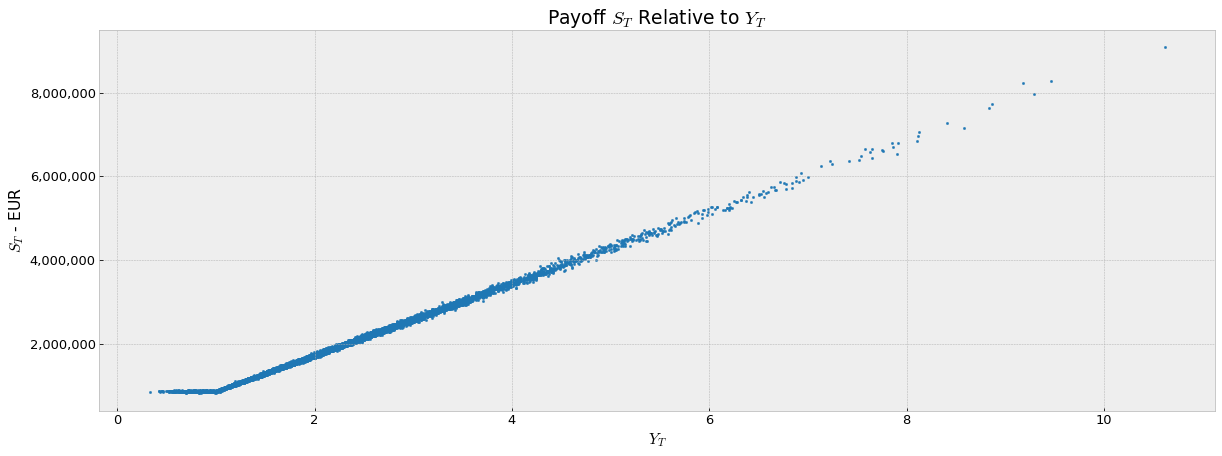

In [244]:
S_T = Payoff_Y * N_paths[:, -1] * P
_in = {'S_T': S_T, 'Y_T': Y_paths[:,-1]}
ax = pd.DataFrame.from_dict(_in).plot(kind='scatter', x='Y_T', y='S_T',xlabel=r'$Y_T$',ylabel=r'$S_T$ - EUR', title=r'Payoff $S_T$ Relative to $Y_T$', marker='.', color='tab:blue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
print(f'Expected S_T = {S_T.mean():,.0f} EUR')

# Neural Network Hedging

In [245]:
def get_phi_psi_VaR(model, X0):
    layer_output1=model.get_layer('Phi_Psi').output
    pw_model = Model(inputs=[model.input], outputs=[layer_output1])

    linear_layer_output = pw_model.predict(X0)

    phi = linear_layer_output[:,0]
    psi = linear_layer_output[:,1]
    return phi, psi


def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

@tf_fun
def quantile_loss(y, y_p):
        quantile = .99
        e = y-y_p
        return keras.backend.mean(keras.backend.maximum(quantile*e, (quantile-1)*e))

lr_scheduler    = keras.callbacks.LearningRateScheduler(scheduler)
quantile_loss_f = lambda y, y_p : quantile_loss(y, y_p)

In [246]:
cost_of_capital = 0.1 * dt

In [247]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.1, seed=1234)
const_initalizer = keras.initializers.RandomNormal(mean=[1-out_of_money_P,out_of_money_P], stddev=0.0, seed=1234)

# model 1
Input_S_N = keras.Input(shape=(3,), name='input: S_{t}, N_{t}, l_{t}') 
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N)
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
holdings = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model1 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_MSE")

#model2
Input_S_N2 = keras.Input(shape=(3,), name='input: S_{t}, N_{t}, l_{t}') 
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N2)
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x2)
holdings2 = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x2)

prices_12 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out2    = keras.layers.Dot(axes = 1, name='V_t')([holdings2, prices_12]) 

model2 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_Q99")
model1.summary()

Model: "Replicating_Portfolio_MSE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input: S_{t}, N_{t}, l_{t} (Inp [(None, 3)]          0                                            
__________________________________________________________________________________________________
LeakyReLU_1 (Dense)             (None, 8)            32          input: S_{t}, N_{t}, l_{t}[0][0] 
__________________________________________________________________________________________________
LeakyReLU_2 (Dense)             (None, 8)            72          LeakyReLU_1[0][0]                
__________________________________________________________________________________________________
Phi_Psi (Dense)                 (None, 2)            18          LeakyReLU_2[0][0]                
__________________________________________________________________________

In [248]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'mse', run_eagerly=False, 
              metrics=["mae", "mape"])
model2.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = quantile_loss_f, run_eagerly=False, 
              metrics=["mae", "mape"])

N_paths_NN      = N_paths / N
values          = np.empty_like(Y_paths)
values[:,-1]    = Payoff_Y * N_paths_NN[:,-1] 

""" Calculate: Payoff for Options """
Flag = True ; its = 0
VaR_HV1     = []
VaR_HV2     = []
Phi_Psi_HV  = []

# Single step excecution ------------------------------------------------
_Y_t  = Y_paths[:,0]
_B_t  = B[:,0]
_Y_t1 = Y_paths[:,1]
_B_t1 = B[:,1]

X0 = [np.stack((_Y_t, N_paths_NN[:,0], L_paths[:,0]), axis=-1), np.stack((_Y_t, _B_t), axis=-1)]
X1 = [np.stack((_Y_t, N_paths_NN[:,0], L_paths[:,0]), axis=-1), np.stack((_Y_t1, _B_t1), axis=-1)]

callabacks = [lr_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]

model1.fit(X1, values[:,1], epochs=500, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
g_t  = model1.predict(X0, verbose=0, batch_size=512).squeeze()
phi1, psi1 = get_phi_psi_VaR(model1, X0)
Res1 = values[:,1] - phi1 * _Y_t1 - psi1 * _B_t1

model2.fit(X1, values[:,1], epochs=500, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)    
h_t  = model2.predict(X0, verbose=0, batch_size=512).squeeze()
phi2, psi2 = get_phi_psi_VaR(model2, X0)

phi = phi1 + cost_of_capital * (phi2 - phi1)
psi = psi1 + cost_of_capital * (psi2 - psi1)

Res2 = values[:,1] - phi * _Y_t1 - psi * _B_t1

values[:,0] = g_t + cost_of_capital*(h_t - g_t)

# Residuals - VaR
* Add N(t) Notation

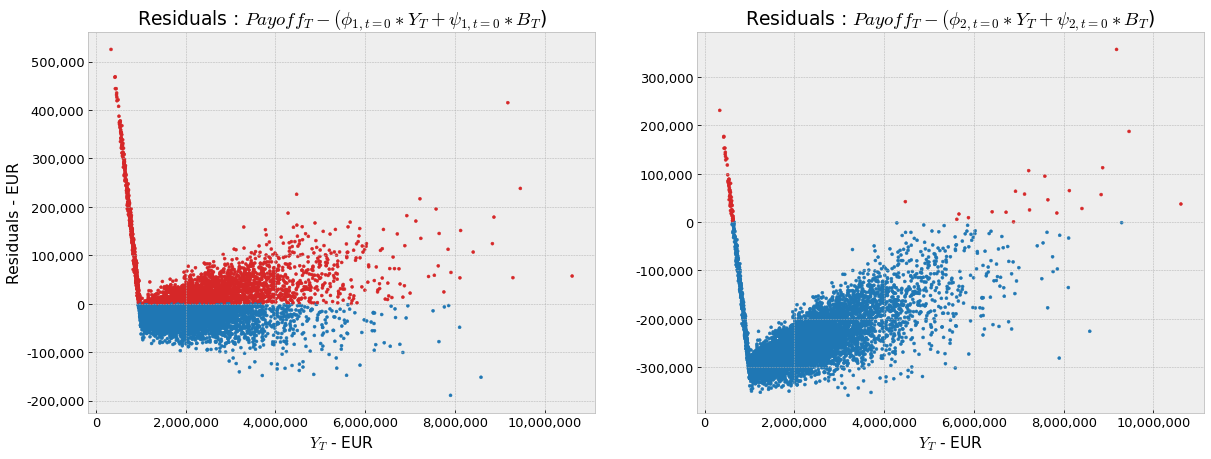

In [249]:
fig, (ax1, ax2) = plt.subplots(1,2) #; fig.subtitle('')
# 1st Plot
c = ['tab:red' if r else 'tab:blue' for r in Res1 > 0]
ax1.scatter(Y_paths[:,-1]* ADJUSTMENT_FACTOR, Res1* ADJUSTMENT_FACTOR, color=c, marker='.')
ax1.set_xlabel(r'$Y_{T}$ - EUR'), ax1.set_ylabel('Residuals - EUR')
ax1.set_title(r'Residuals : $Payoff_T - (\phi_{1,t=0}*Y_T + \psi_{1,t=0}*B_T$)')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# 2st Plot
c = ['tab:red' if r else 'tab:blue' for r in Res2 > 0]
ax2.scatter(Y_paths[:,-1]* ADJUSTMENT_FACTOR, Res2* ADJUSTMENT_FACTOR, color=c, marker='.')
ax2.set_xlabel(r'$Y_{T}$ - EUR'), ax1.set_ylabel('Residuals - EUR')
ax2.set_title(r'Residuals : $Payoff_T - (\phi_{2,t=0}*Y_T + \psi_{2,t=0}*B_T$)')
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

In [250]:
print(f'Overall VaR(98.5%) = {np.quantile(Res1, .985):.5f}')
print(f'Overall VaR(99.0%) = {np.quantile(Res1, .99):.5f}')
print(f'Overall VaR(99.5%) = {np.quantile(Res1, .995):.5f}')
print('------------------------------------------')
print(f'Overall VaR(98.5%) = {np.quantile(Res2, .985):.5f}')
print(f'Overall VaR(99.0%) = {np.quantile(Res2, .99):.5f}')
print(f'Overall VaR(99.5%) = {np.quantile(Res2, .995):.5f}')

Overall VaR(98.5%) = 0.21373
Overall VaR(99.0%) = 0.25823
Overall VaR(99.5%) = 0.32456
------------------------------------------
Overall VaR(98.5%) = -0.02974
Overall VaR(99.0%) = 0.00085
Overall VaR(99.5%) = 0.05162


# Hedging Values

In [251]:
print(f'Phi t=0 : {phi.mean()* ADJUSTMENT_FACTOR:,.0f} Stocks')
print(f'Psi t=0 : {psi.mean()* ADJUSTMENT_FACTOR:,.0f} Bonds')

Phi t=0 : 819,539 Stocks
Psi t=0 : 257,308 Bonds


ADJUS_TTED 
--------------------------------------------
Value at t_0 (Replicating-P)  = 1,076,846.838
Discounted Eq[S_T] ADJ          = 1,424,644.150
 Difference                   = -347,797.312 : -24.413% 
Discounted Ep[S_T] ADJ          = 864,090.356
 Difference                   = 212,756.482   : 24.622% 
Total Premium at t0           = 1,000,000 
Profit w/o TC                 = -76,847


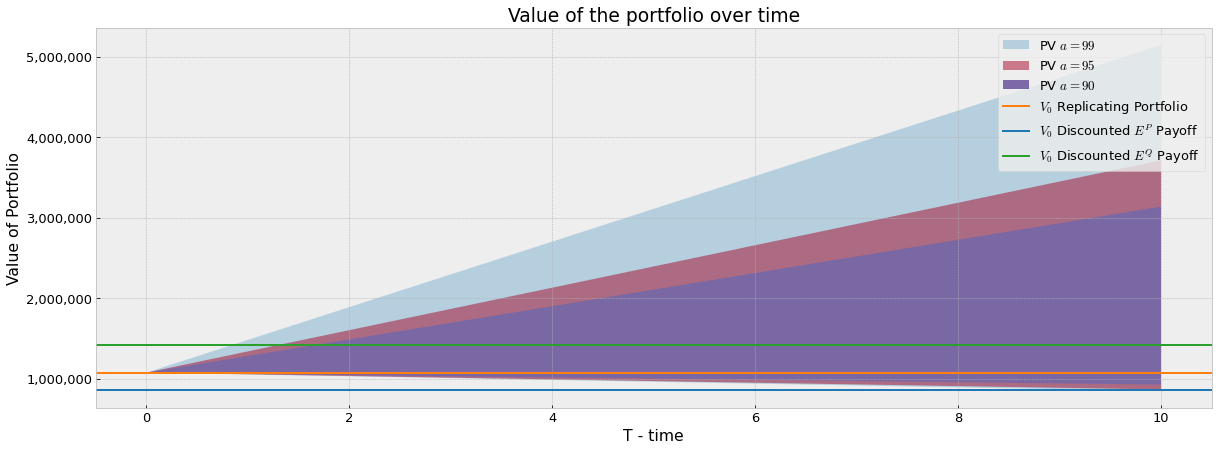

In [252]:
V0_RP = values[:,0].mean() * ADJUSTMENT_FACTOR

qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0) * ADJUSTMENT_FACTOR
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
plt.ticklabel_format(style='plain', useLocale=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.axhline(V0_RP, color='tab:orange')
ax.axhline(S_T.mean() * np.exp(-mu*T), color='tab:blue')
ax.axhline(S_T.mean() * np.exp(-r*T), color='tab:green')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Discounted $E^P$ Payoff', r'$V_0$ Discounted $E^Q$ Payoff'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print('ADJUS_TTED \n--------------------------------------------')
print(f'Value at t_0 (Replicating-P)  = {V0_RP:,.3f}')
print(f'Discounted Eq[S_T] ADJ          = {S_T.mean() * np.exp(-r*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-r*T):,.3f} : {(V0_RP - S_T.mean() * np.exp(-r*T) )/(S_T.mean() * np.exp(-r*T)) * 100:,.3f}% ')
print(f'Discounted Ep[S_T] ADJ          = {S_T.mean() * np.exp(-mu*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-mu*T):,.3f}   : {(V0_RP - S_T.mean() * np.exp(-mu*T) )/ (S_T.mean() * np.exp(-mu*T) ) * 100:,.3f}% ')
print(f'Total Premium at t0           = {ADJUSTMENT_FACTOR:,} \nProfit w/o TC                 = {ADJUSTMENT_FACTOR - V0_RP:,.0f}')

plt.show()